# Example 1 - Analyze RNA-seq Data

## Introduction
This code is designed to handle RNA-seq data that has been pre-processed to the point where gene names, fold change, and statistical analyses have been determined.  
The input data, which will be processed using the `Cleaner` class, is an `.xlsx` table with the following mandatory columns:

- **row** (gene name)
- **log2FoldChange**
- **padj**

<div style="border: 1px solid red; padding: 10px; background-color: #f8d7da; color: #721c24; border-radius: 5px;">
    <strong>Alert:</strong> It's important to note that while additional columns may exist in the file, these three columns are mandatory.
</div>

## Cleaner class
The `Cleaner` class goal is to clean NaN values that exist in the raw data, and to remove undesired rows (that is, rows that the reading is not statistically significant).
First, lets view the raw data that we take as input to our code:

In [2]:
import pandas as pd

# Define the file path
raw_data = 'example_data/results_deseq2.xlsx'

# Load the Excel file into a DataFrame
df = pd.read_excel(raw_data, engine='openpyxl')

# Display the DataFrame
df.head()

,Unnamed: 0,row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,1,4933401J01Rik,0.000000,NaN,NaN,NaN,NaN,NaN
1,2,Gm26206,0.000000,NaN,NaN,NaN,NaN,NaN
2,3,Xkr4,20.685986,0.136808,1.380041,0.099133,0.921032,0.999961
3,4,Gm18956,0.000000,NaN,NaN,NaN,NaN,NaN
4,5,Gm37180,0.000000,NaN,NaN,NaN,NaN,NaN


As you can see, the data has a lot of NaN values. Lets clean them with our `Cleaner` class:

In [3]:
import sys
import os

# Add the main directory (root) to the Python path
sys.path.append(os.path.abspath(".."))

# Now you can import from the main directory
from cleaning import DataCleaning

# Example usage
cleaner = DataCleaning(raw_data)
cleaned_data = cleaner.clean_data(column_name_to_filter='padj', threshold=0.05, condition='smaller', column_name_to_remove='Unnamed: 0')

cleaned_data.head()

,row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,Ccdc3,384.813937,2.655578,0.543246,4.888351,1.016843e-06,6.698454e-04
1,Camk1d,7129.248384,-3.144309,0.302446,-10.396266,2.578408e-25,5.284304e-22
2,Cytip,428.778978,-1.493588,0.384760,-3.881874,1.036547e-04,3.476202e-02
3,Zfp831,78.243439,4.487587,1.184239,3.789428,1.509948e-04,4.437255e-02
4,AI838599,134.293932,5.606520,1.140670,4.915110,8.873279e-07,6.061764e-04


As you can see, the data has been cleaned from NaN values.  
The `Cleaner.clean_data()` method takes several variables as arguments. One of them is the threshold argument.  
This argument allows us to filter out statistically unsignificant results. Lets assume we acknowledge results that are with adjusted p-value of 0.1,  
which allows us to view also trends in our data.  
The following code will compare the size of the cleaned dataframe when using 0.05 or 0.1 threshold

In [4]:
cleaner_005 = DataCleaning(raw_data)
cleaner_010 = DataCleaning(raw_data)
cleaned_data_005 = cleaner_005.clean_data(column_name_to_filter='padj', threshold=0.05, condition='smaller', column_name_to_remove='Unnamed: 0')
cleaned_data_010 = cleaner_010.clean_data(column_name_to_filter='padj', threshold=0.1, condition='smaller', column_name_to_remove='Unnamed: 0')


print(f"0.05 Threshold df size: {cleaned_data_005.shape}")
print(f"0.1 Threshold df size: {cleaned_data_010.shape}")

0.05 Threshold df size: (65, 7)
0.1 Threshold df size: (73, 7)


From this example we can see that 8 genes have a trend towards a gene, while 65 are statistically significant.  
One of the main features our code provides is to to find which pathway a gene is associated with.  
Moreover, our code allows the user to chose which datasets to use for that determination. 
reactome.org is a well known database that shows which pathway a gene is accociated with.  
The following code will add to the dataset a new column, specifying one or more pathways that each gene is part of. 
<div style="border: 1px solid orange; padding: 10px; background-color: #f8d7da; color: #721c24; border-radius: 5px;">
    <strong>Note:</strong> Note that this code might take a while, as the function `scrape_for_pathway()` is scarping out the value of each gene 
</div>

In [5]:
from scraping import scrape_for_pathway

raw_data = 'example_data/results_deseq2.xlsx'
cleaner = DataCleaning(raw_data)
cleaned_data = cleaner.clean_data(column_name_to_filter='padj',threshold=0.1,condition = 'smaller', column_name_to_remove='Unnamed: 0')
related_pathway = []
for gene_name in cleaned_data['row']:
    pathway_name = scrape_for_pathway(gene_name)
    related_pathway.append(pathway_name)
cleaned_data['related pathway'] = related_pathway

cleaned_data

,row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,related pathway
0,Ccdc3,384.813937,2.655578,0.543246,4.888351,1.016843e-06,6.698454e-04,[]
1,Camk1d,7129.248384,-3.144309,0.302446,-10.396266,2.578408e-25,5.284304e-22,[]
2,Cytip,428.778978,-1.493588,0.384760,-3.881874,1.036547e-04,3.476202e-02,[]
3,Ptgis,159.270002,2.765021,0.748028,3.696413,2.186675e-04,5.931357e-02,[Metabolism (Homo sapiens)]
4,Zfp831,78.243439,4.487587,1.184239,3.789428,1.509948e-04,4.437255e-02,[]
...,...,...,...,...,...,...,...,...
68,Rpl3-ps1,291.622486,-1.784719,0.471493,-3.785247,1.535559e-04,4.437255e-02,"[Metabolism of proteins (Homo sapiens), Metabo..."
69,Col4a5,2133.240828,1.744954,0.283141,6.162844,7.144992e-10,7.752316e-07,[Extracellular matrix organization (Homo sapie...
70,Htr2c,78.369873,3.063292,0.862671,3.550939,3.838596e-04,9.833735e-02,[Signal Transduction (Homo sapiens)]
71,mt-Rnr1,27477.313052,-3.533308,0.266254,-13.270425,3.436267e-40,1.056366e-36,[Signal Transduction (Homo sapiens)]


We can also visualize the data using `RNABarPlotter` Class.
The following code does just that.

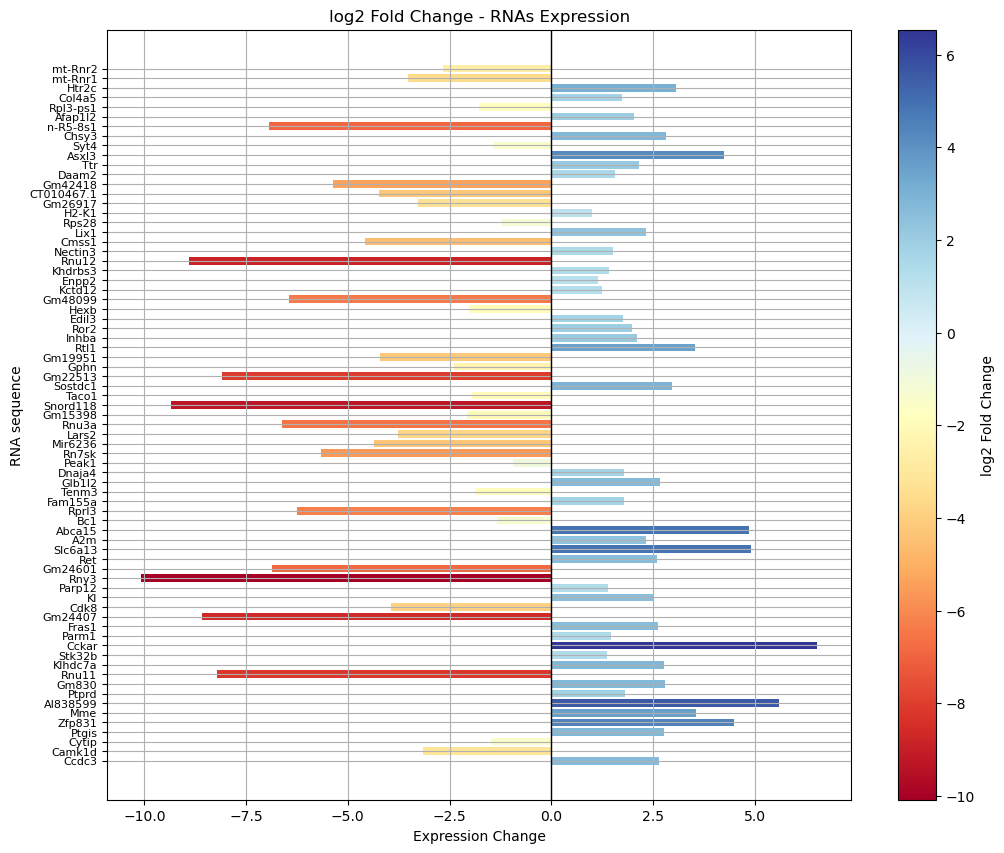

In [6]:
from data_visualizations import RNABarPlotter

bar_plot = RNABarPlotter(cleaned_data)
bar_plot.plot(0.05)

Lets assume that we are intereseted only in protein coding genes.  
The following code will allow to filter out genes that are not protein coding, according to ensemble database.

In [7]:
from filter_protein_coding_genes import *

protein_coding_genes = download_protein_coding_genes()
cleaned_data = filter_protein_coding_genes(cleaned_data, protein_coding_genes)

cleaned_data


We can also plot XXX. But before we do that, we need to prepare our data.  
For XXX plot, we need also YYY and ZZZ values for each gene.  
The following line of code will prepare the dataframe and create XXX plot.

As is visible in the above table, the 'related pathway' column was added, with values related to each gene with relatively 'general' pathway.  
If, however, one is interested in more specific pathways that each gene is part of,  
it is possible to use another function, named `enrich_gene()`, that will provide greater detail for each gene.  
This function is relies on blabla python library, which has access to a wide range of databases.

In [8]:
from concurrent.futures import ThreadPoolExecutor 
from DataProcessing_PythonLibraries import *

with ThreadPoolExecutor(max_workers=8) as executor:  
    related_pathways = list(executor.map(enrich_gene, cleaned_data['row']))

cleaned_data['related pathways'] = related_pathways

#num of gene with path and num of errors 
genes_with_pathways = cleaned_data[(cleaned_data['related pathways'] != 'No related pathways found') & (df_cleaned['related pathways'] != 'Error during enrichment')]
count_genes_with_pathways = genes_with_pathways.shape[0]
errors= cleaned_data[cleaned_data ['related pathways'] == 'Error during enrichment']
count_errors=errors.shape[0]

cleaned_data

/Users/zivbentulila/anaconda3/envs/python_lab_course/lib/python3.11/site-packages/gseapy/enrichr.py:643: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results = pd.concat(self.results, ignore_index=True)
/Users/zivbentulila/anaconda3/envs/python_lab_course/lib/python3.11/site-packages/gseapy/enrichr.py:643: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results = pd.concat(self.results, ignore_index=True)
/Users/zivbentulila/anaconda3/envs/python_lab_course/lib/python3.11/site-packages/

KeyboardInterrupt: 

More information about all the functions shown in this example are shown in the DOCSTRING for each function.

Pre Processing for Volcano Plot